#First of all
This notebook should be run in google colab because of gpu it provides.

Let's import  necessary libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import os
import yaml


import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from PIL import Image
from IPython.display import display
from pathlib import Path

import cv2
from google.colab.patches import cv2_imshow  # This is specific to Google Colab


We have to import `kaggle.json` file to download dataset and prepare directory to extract zip file we will download.

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maryanpetlyovanyy","key":"d1656d34430a1dedc3c4b95bd129d671"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d khlaifiabilel/military-aircraft-recognition-dataset -p /content/


100% 1.12G/1.13G [00:11<00:00, 85.5MB/s]
100% 1.13G/1.13G [00:11<00:00, 106MB/s] 


In [5]:
!unzip /content/military-aircraft-recognition-dataset.zip -d /content/military-aircraft-recognition-dataset/


Streaming output truncated to the last 5000 lines.
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3416.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3417.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3418.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3419.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/342.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3420.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3421.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3422.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxe

Also I will upload `horizontal.csv` and `oriented.csv` files that I have made with my `src/process.py`

In [6]:
files.upload()

Saving horizontal.csv to horizontal.csv
Saving oriented.csv to oriented.csv


{'horizontal.csv': b',name,image_width,image_height,class,xmin,ymin,xmax,ymax\r\n0,1.jpg,859,831,A2,485,427,554,500\r\n1,1.jpg,859,831,A2,694,487,770,562\r\n2,1.jpg,859,831,A10,58,205,134,285\r\n3,10.jpg,752,834,A2,510,44,635,149\r\n4,10.jpg,752,834,A2,497,354,618,459\r\n5,10.jpg,752,834,A2,478,667,598,774\r\n6,10.jpg,752,834,A2,613,599,729,711\r\n7,100.jpg,755,755,A3,327,94,369,143\r\n8,100.jpg,755,755,A3,448,31,493,76\r\n9,100.jpg,755,755,A3,448,80,495,124\r\n10,100.jpg,755,755,A3,448,128,494,172\r\n11,100.jpg,755,755,A3,450,176,496,220\r\n12,100.jpg,755,755,A3,336,608,382,653\r\n13,1000.jpg,800,800,A2,91,133,197,237\r\n14,1000.jpg,800,800,A2,380,602,510,701\r\n15,1000.jpg,800,800,A3,633,573,784,718\r\n16,1001.jpg,800,800,A2,170,227,285,300\r\n17,1001.jpg,800,800,A3,342,442,467,533\r\n18,1001.jpg,800,800,A3,537,443,658,535\r\n19,1001.jpg,800,800,A3,349,633,478,735\r\n20,1002.jpg,800,800,A19,45,203,138,280\r\n21,1002.jpg,800,800,A19,92,279,184,355\r\n22,1002.jpg,800,800,A19,135,354,22

I'm going to define utility functions for process the data from csv.

In [2]:
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, INPUT_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the pixels
    return image


def preprocess_bounding_boxes(annotations, image_width, image_height, target_size):
    xmin = annotations['xmin']
    ymin = annotations['ymin']
    xmax = annotations['xmax']
    ymax = annotations['ymax']

    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)
    xmax = tf.cast(xmax, tf.float32)
    ymax = tf.cast(ymax, tf.float32)

    width_scale = target_size[0] / image_width
    height_scale = target_size[1] / image_height

    xmin = xmin * width_scale
    ymin = ymin * height_scale
    xmax = xmax * width_scale
    ymax = ymax * height_scale

    bounding_boxes = tf.stack([xmin, ymin, xmax, ymax], axis=-1)

    return bounding_boxes

Let's define config for our first model(or import)

In [8]:
files.upload()

Saving model1.yaml to model1.yaml


{'model1.yaml': b'model1:\r\n  INPUT_SIZE: [416, 416]\r\n  N_SAMPLES: 1000\r\n  LR: 1e-3\r\n  BATCH_SIZE: 32\r\n  EPOCHS: 50\r\n'}

In [3]:
with open('model1.yaml', 'r') as yaml_file:
  config = yaml.safe_load(yaml_file)

if config:
  INPUT_SIZE = config['model1']['INPUT_SIZE']
  N_SAMPLES = config['model1']['N_SAMPLES']
  LR = float(config['model1']['LR'])
  BATCH_SIZE = config['model1']['BATCH_SIZE']
  EPOCHS = config['model1']['EPOCHS']
else:
  INPUT_SIZE = (416,416)
  N_SAMPLES = 1000
  LR = 1e-3
  BATCH_SIZE = 32
  EPOCHS = 50

Let's import our `horizontal.csv` file and get N samples from dataset

In [4]:
data_path = './horizontal.csv'
df = pd.read_csv(data_path)
df = df[:N_SAMPLES]
df = df[df['class'] != 'A6']
df = df[df['class'] != 'A18']
df["class"].value_counts()

A2     130
A16     95
A1      95
A19     78
A13     71
A3      62
A14     59
A17     56
A5      48
A7      47
A20     46
A15     43
A9      36
A4      35
A10     32
A8      22
A12     20
A11     20
Name: class, dtype: int64

Let's get our class labels and make one-hot encoding  

In [5]:
class_labels = df['class'].unique()
class_labels = {label: i for i, label in enumerate(class_labels)}
num_classes = len(class_labels)
class_labels

{'A2': 0,
 'A10': 1,
 'A3': 2,
 'A19': 3,
 'A1': 4,
 'A13': 5,
 'A20': 6,
 'A15': 7,
 'A16': 8,
 'A17': 9,
 'A12': 10,
 'A5': 11,
 'A14': 12,
 'A7': 13,
 'A9': 14,
 'A4': 15,
 'A8': 16,
 'A11': 17}

In [6]:
df['class_id'] = df['class'].map(class_labels)
labels = tf.cast(df['class_id'], tf.int32)
labels

<tf.Tensor: shape=(995,), dtype=int32, numpy=
array([ 0,  0,  1,  0,  0,  0,  0,  2,  2,  2,  2,  2,  2,  0,  0,  2,  0,
        2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  3,  3,  3,  3,  3,  5,
        6,  6,  6,  6,  6,  0,  1,  7,  7,  8,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  9,  9,  9,  9,  9,  9,  2,  2,  2,  2,  3,  3,  4,
        4,  4,  3,  3,  3,  3,  3,  3,  3,  3,  9, 10, 10, 10, 10,  9, 11,
       11, 11, 11,  5,  5,  5,  5,  5,  5,  5,  5,  9,  9,  9, 10, 10, 10,
        4,  4,  3,  4,  3,  3,  3,  4,  4,  4,  4, 12, 12, 12,  0,  0,  0,
        0,  0,  2,  0,  0,  4,  4,  3,  4,  4,  4,  4,  0,  0,  0,  5,  5,
        5,  5,  5,  5,  5,  6,  6, 13, 13, 13, 13,  8,  8,  8,  8,  8,  7,
        7,  7,  7,  7,  7,  4,  4,  4,  4,  9,  9,  9,  8,  8,  8,  8,  8,
        8,  8,  8, 13, 13,  6,  6,  6,  6,  3,  3,  3, 12, 12, 12, 12, 12,
        5,  0,  5,  5,  4,  4,  4,  4,  3,  4,  4,  4,  4,  4,  4,  4,  3,
        3,  4, 14, 14, 14,  5,  5,  5,  5, 11, 11,  8,

In [7]:
labels = tf.one_hot(labels, depth=tf.reduce_max(labels) + 1)
labels

<tf.Tensor: shape=(995, 18), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

Get full paths for images.

In [8]:
image_paths = "/content/military-aircraft-recognition-dataset/JPEGImages/" + df["name"]
len(image_paths), image_paths[0]

(995, '/content/military-aircraft-recognition-dataset/JPEGImages/1.jpg')

Import original width and height of images

In [9]:
w = np.array(df["image_width"])
h = np.array(df["image_height"])

Let's make tensors from paths

In [10]:
X = [load_and_preprocess_image(image_path) for image_path in image_paths]


Get bounding boxes scaled to image size.

In [11]:
bounding_boxes = preprocess_bounding_boxes(df, w, h, INPUT_SIZE)
bounding_boxes

<tf.Tensor: shape=(995, 4), dtype=float32, numpy=
array([[234.87776 , 213.75693 , 268.29337 , 250.30086 ],
       [336.09314 , 243.79303 , 372.8987  , 281.33817 ],
       [ 28.088474, 102.62335 ,  64.89406 , 142.6715  ],
       ...,
       [209.56    , 193.43999 , 262.08    , 245.43999 ],
       [ 44.199997, 178.87999 ,  96.2     , 228.28    ],
       [222.04    , 279.24    , 273.52    , 329.15997 ]], dtype=float32)>

In [12]:
len(X), len(labels), len(bounding_boxes)

(995, 995, 995)

It seems that all the data is preprocessed and is ready to use. It is time to split it into train/test. I will use test set as validation

In [13]:
split= train_test_split(np.array(X), np.array(labels), np.array(bounding_boxes), test_size=0.2, random_state=42)
X_train, X_test, labels_train, labels_test, bbox_train, bbox_test = split

In [14]:
y_train  = {'classification': labels_train,
            'bounding_box': bbox_train}
y_test  = {'classification': labels_test,
            'bounding_box': bbox_test}

Final check of data I will fit to the model

[296  24 341  75]


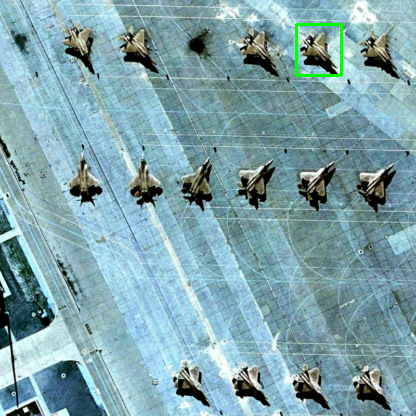

[300 170 345 206]


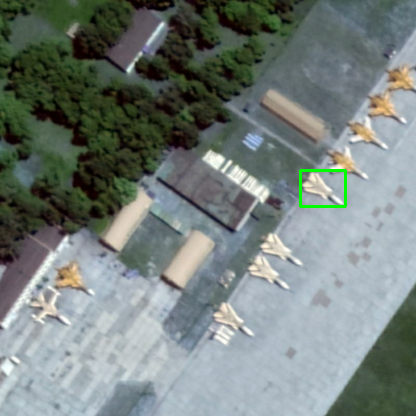

[157  46 190  86]


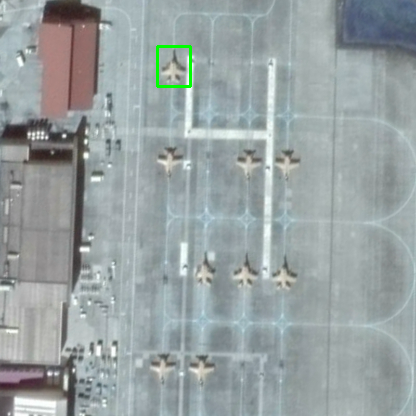

[108  37 199 121]


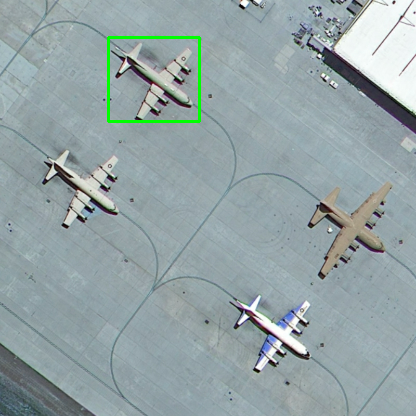

[ 63 145 107 199]


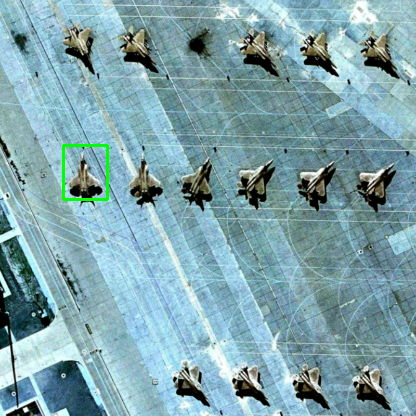

[166 358 213 405]


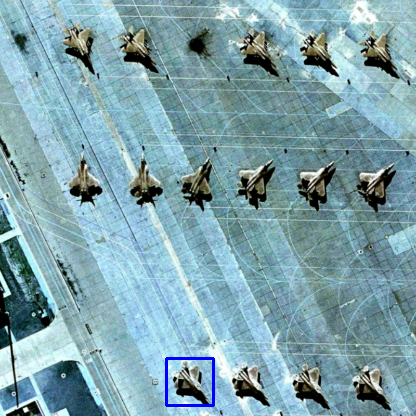

[ 85 330 132 364]


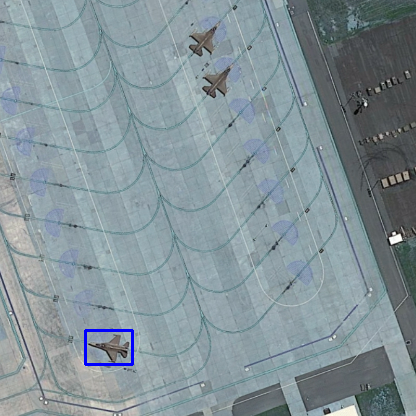

[299  34 331  62]


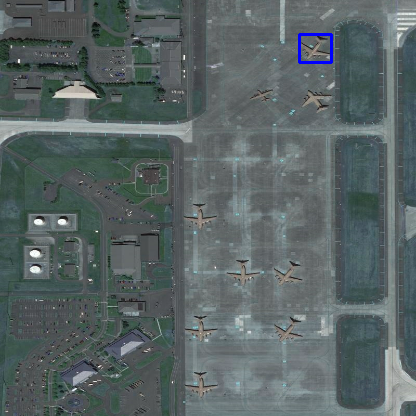

[ 74 119 124 167]


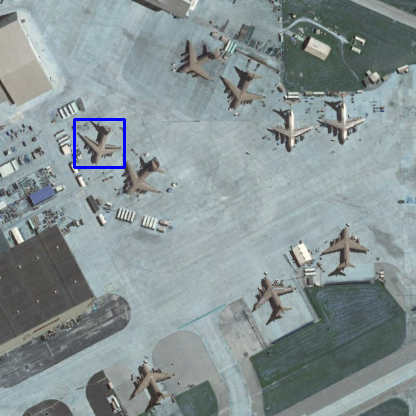

[269 345 308 393]


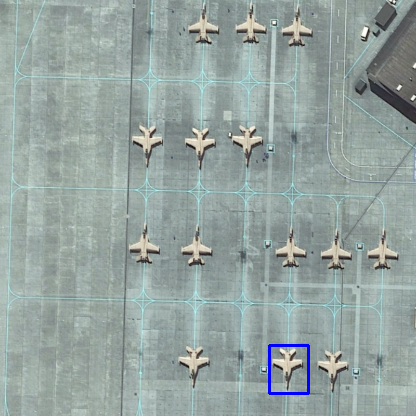

In [15]:
from google.colab.patches import cv2_imshow
for i in range(5):
  image = X_train[i]*255
  bbox = y_train['bounding_box'][i].astype(int)
  print(bbox)
  image = cv2.rectangle(image, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (0,255,0), 2)
  cv2_imshow(image)

for i in range(5):
  image = X_test[i]*255
  bbox = y_test['bounding_box'][i].astype(int)
  print(bbox)
  image = cv2.rectangle(image, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (255,0,0), 2)
  cv2_imshow(image)



For the first model I'm going to try VGG16 model what seems to be a good for detection and classification task.

I'm going to use Tensorflow Functional API because I am going to make classification and bbox heads.

In [16]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*INPUT_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False

# Classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax', name='classification')(x)

# Bounding box regression head
y = base_model.output
y = Flatten()(y)
y = Dense(512, activation='relu')(y)
y = Dense(256, activation='relu')(y)
bounding_box_output = Dense(4, activation='relu', name='bounding_box')(y)

combined_model = Model(inputs=base_model.input, outputs=[predictions, bounding_box_output])

I am going to use:

*   Adaptive momentum optimizer with learning rate(without learning rate scheduling for now)

*   Categorical crossentropy for classification and MAE for bboxes



*   Accuracy metrics for classification and nothing for bbox


In [17]:
combined_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss={
        'classification': 'categorical_crossentropy',
        'bounding_box': 'mae'
    },
    metrics={
        'classification': 'accuracy'
    }
)

In [18]:
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 416, 416, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 416, 416, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 208, 208, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

As I use google colab, I have access to Nvidia T4 GPU so I will train my model for 50(depends on config) epochs and batch_size of 32(depends on config)

In [19]:
history = combined_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/50
25/25 [==============================] - 57s 1s/step - loss: 167.9401 - classification_loss: 2.6843 - bounding_box_loss: 165.2558 - classification_accuracy: 0.2073 - val_loss: 131.0925 - val_classification_loss: 2.2308 - val_bounding_box_loss: 128.8616 - val_classification_accuracy: 0.3065
Epoch 2/50
25/25 [==============================] - 17s 673ms/step - loss: 129.1684 - classification_loss: 2.1832 - bounding_box_loss: 126.9852 - classification_accuracy: 0.3128 - val_loss: 129.4672 - val_classification_loss: 1.8833 - val_bounding_box_loss: 127.5839 - val_classification_accuracy: 0.4472
Epoch 3/50
25/25 [==============================] - 14s 582ms/step - loss: 125.7345 - classification_loss: 1.9325 - bounding_box_loss: 123.8020 - classification_accuracy: 0.3832 - val_loss: 130.2727 - val_classification_loss: 1.7010 - val_bounding_box_loss: 128.5717 - val_classification_accuracy: 0.3970
Epoch 4/50
25/25 [==============================] - 17s 681ms/step - loss: 124.3355 - cl

In [20]:
combined_model.evaluate(X_test, y_test)

7/7 [==============================] - 3s 386ms/step - loss: 135.4131 - classification_loss: 0.6148 - bounding_box_loss: 134.7983 - classification_accuracy: 0.7889


[135.4130859375, 0.614764392375946, 134.79832458496094, 0.7889447212219238]

So we reached Loss of bbox+class ~99, classification accuracy about 82%

To be honest, I am not satisfied let's look to the confusion metrics and histroy plot and switch to the second model

I have some util functions I created before you can check on [my github](https://github.com/MarianPetlovanyi/ML-colab-notebooks/blob/main/utils/helper_functions.py) and I' going to use one of this but I have to modify it a little bit


In [21]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20,20), text_size=15, norm=False, savefig=False):
  cm = confusion_matrix(y_true, y_pred);
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()


  threshold = (cm.max() + cm.min())/2

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j,i, f"{cm[i,j]} ({cm_norm[i,j]*100:.1f}%)",
               horizontalalignment="center",
               color="white" if cm[i,j] > threshold else "black",
               size = text_size)
    else:
      plt.text(j,i, f"{cm[i,j]}",
               horizontalalignment="center",
               color="white" if cm[i,j] > threshold else "black",
               size=text_size)

    if savefig:
      fig.savefig("confusion_matrix.png")

In [22]:
def plot_loss_curves(history):
  classification_loss = history.history['classification_loss']
  val_classification_loss = history.history['val_classification_loss']

  classification_accuracy = history.history['classification_accuracy']
  val_classification_accuracy = history.history['val_classification_accuracy']

  bounding_box_loss = history.history['bounding_box_loss']
  val_bounding_box_loss = history.history['val_bounding_box_loss']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, classification_loss, label='training_classification_loss')
  plt.plot(epochs, val_classification_loss, label='val_classification_loss')
  plt.title('loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, classification_accuracy, label='training_classification_accuracy')
  plt.plot(epochs, val_classification_accuracy, label='val_classification_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, bounding_box_loss, label='training_bounding_box_loss')
  plt.plot(epochs, val_bounding_box_loss, label='val_bounding_box_loss')
  plt.title('loss')
  plt.xlabel('Epochs')
  plt.legend()


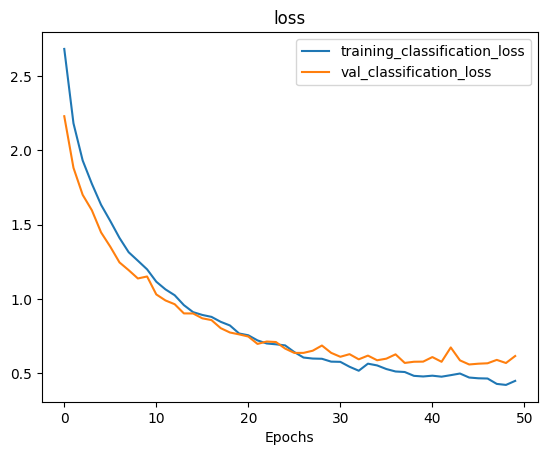

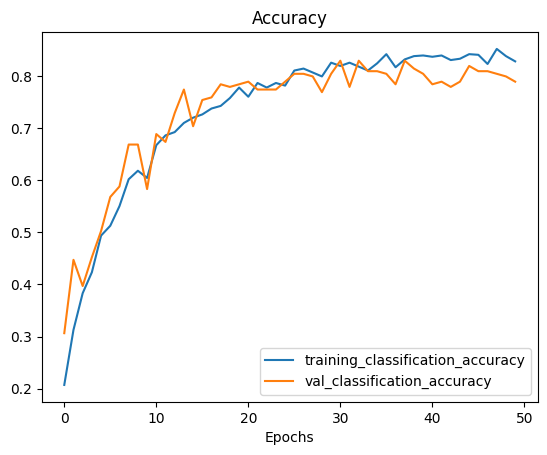

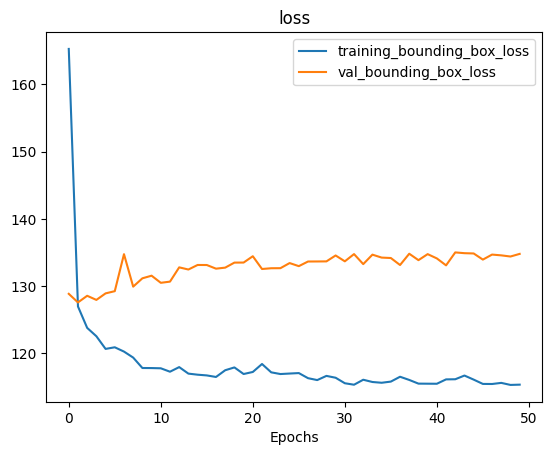

In [23]:
plot_loss_curves(history )

In [24]:
y_pred = combined_model.predict(X_test)

7/7 [==============================] - 3s 426ms/step


In [25]:
reverse_class_labels = {value: key for key, value in class_labels.items()}
labels = reverse_class_labels.values()

In [26]:
y_true_values = np.argmax(y_test['classification'],axis=1)
y_pred_values = np.argmax(y_pred[0],axis=1)

In [27]:
cm = confusion_matrix(y_true_values, y_pred_values, labels = list(reverse_class_labels.keys()))
cm.shape

(18, 18)

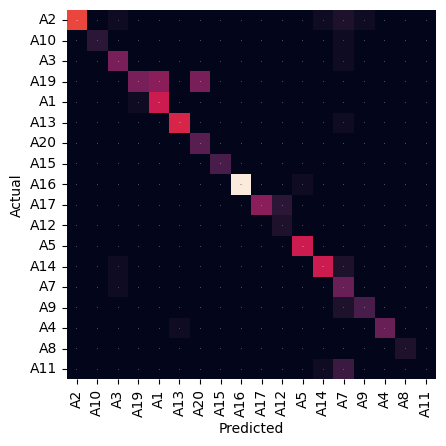

In [28]:
import seaborn as sns

df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 1}, square=True, cbar=False, fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [36]:
def calculate_precision_recall_f1_accuracy(confusion_matrix):
    confusion_matrix = confusion_matrix[:-1, :-1]
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)

    correct_predictions = np.sum(np.diag(confusion_matrix))
    total_predictions = np.sum(confusion_matrix)
    accuracy = correct_predictions / total_predictions

    return precision, recall, f1_score, accuracy

precision, recall, f1_score, accuracy = calculate_precision_recall_f1_accuracy(cm)

print("Precision:", np.mean(precision))
print("Recall:", np.mean(recall))
print("F1 Score:", np.mean(f1_score))
print("Accuracy:", accuracy)

Precision: 0.82923245055598
Recall: 0.8572027699968876
F1 Score: 0.8101989460251522
Accuracy: 0.8092783505154639
